  class_name  survival_rate
0      First       0.629630
1     Second       0.472826
2      Third       0.242363


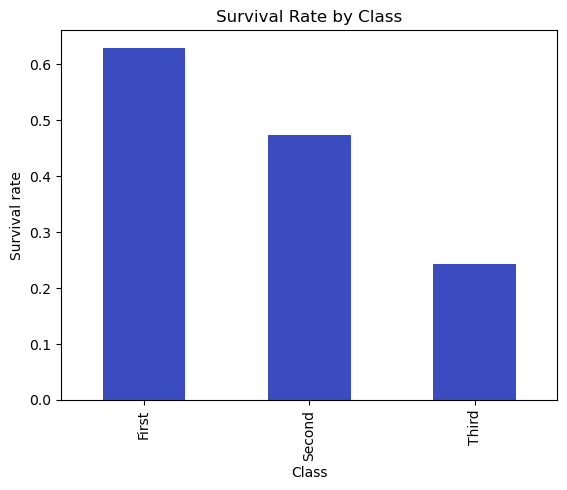

In [1]:
# Step 1: Importing necessary modules
import seaborn as sns
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Step 2: Loading the Titanic dataset from Seaborn
df_raw = sns.load_dataset("titanic")

# Step 3: Renaming columns to match schema and adding placeholder names for presentation
# (Seaborn has no 'name' column)
df_raw = df_raw.rename(columns={
'pclass': 'pclass_id',
'sibsp': 'siblings_spouses',
'parch': 'parents_children'
})
df_raw['name'] = ['Passenger ' + str(i+1) for i in range(len(df_raw))]

# Step 3: Connecting to SQLite database
conn = sqlite3.connect('titanic.db')
cursor = conn.cursor()

# Step 4: Creating normalized tables (drops if they already exist) i.e. forming the schema
schema_sql = """
DROP TABLE IF EXISTS passengers;
DROP TABLE IF EXISTS passenger_classes;
DROP TABLE IF EXISTS tickets;
DROP TABLE IF EXISTS cabins;

CREATE TABLE passenger_classes (
pclass_id INT PRIMARY KEY,
class_name TEXT NOT NULL
);

CREATE TABLE tickets (
ticket_id INTEGER PRIMARY KEY AUTOINCREMENT,
fare DECIMAL,
embarked TEXT
);

CREATE TABLE cabins (
cabin_id INTEGER PRIMARY KEY AUTOINCREMENT,
deck TEXT
);

CREATE TABLE passengers (
passenger_id INTEGER PRIMARY KEY,
name TEXT,
sex TEXT,
age DECIMAL,
siblings_spouses INT,
parents_children INT,
pclass_id INT,
ticket_id INT,
cabin_id INT,
survived INT,
FOREIGN KEY (pclass_id) REFERENCES passenger_classes(pclass_id),
FOREIGN KEY (ticket_id) REFERENCES tickets(ticket_id),
FOREIGN KEY (cabin_id) REFERENCES cabins(cabin_id)
);
"""
cursor.executescript(schema_sql)
conn.commit()

# Step 5: Loading raw DataFrame into a temporary table
df_raw.to_sql('titanic_raw', conn, if_exists='replace', index=False)

# Step 6: Populating each table from the schema with data from the raw DataFrame
cursor.execute("""
INSERT INTO passenger_classes (pclass_id, class_name)
VALUES (1, 'First'), (2, 'Second'), (3, 'Third');
""")

cursor.execute("""
INSERT INTO tickets (fare, embarked)
SELECT DISTINCT fare, embarked
FROM titanic_raw;
""")

cursor.execute("""
INSERT INTO cabins (deck)
SELECT DISTINCT deck
FROM titanic_raw
WHERE deck IS NOT NULL;
""")

cursor.execute("""
INSERT INTO passengers (
passenger_id, name, sex, age,
siblings_spouses, parents_children,
pclass_id, ticket_id, cabin_id, survived
)
SELECT
row_number() OVER () AS passenger_id,
name,
sex,
age,
siblings_spouses,
parents_children,
pclass_id,
(SELECT ticket_id FROM tickets t
WHERE t.fare = r.fare AND (t.embarked = r.embarked OR (t.embarked IS NULL AND r.embarked IS NULL))
LIMIT 1) AS ticket_id,
(SELECT cabin_id FROM cabins c
WHERE c.deck = r.deck
LIMIT 1) AS cabin_id,
survived
FROM titanic_raw r;
""")
conn.commit()

# Step 7: Sample query (survival rate by class)
query = """
SELECT pc.class_name, AVG(p.survived) AS survival_rate
FROM passengers p
JOIN passenger_classes pc ON p.pclass_id = pc.pclass_id
GROUP BY pc.class_name
ORDER BY survival_rate DESC;
"""

df_result = pd.read_sql_query(query, conn)
print(df_result)
df_result.plot(kind='bar', x='class_name', y='survival_rate', title='Survival Rate by Class', legend=False, xlabel='Class', ylabel='Survival rate', cmap='coolwarm')
plt.savefig('plots/class_survival.png', dpi=300, bbox_inches='tight')

  class_name     sex  survival_rate  passengers_count
0      First  female       0.968085                94
1      First    male       0.368852               122
2     Second  female       0.921053                76
3     Second    male       0.157407               108
4      Third  female       0.500000               144
5      Third    male       0.135447               347


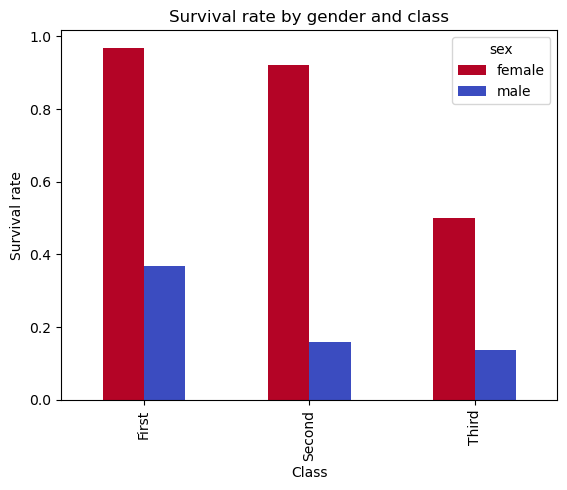

In [2]:
# Step 8: Subquerying the survival rate by class and by sex
# Links each passenger to their class (in text form - their class no. is already stored) and groups by both class and sex

query = """
SELECT pc.class_name,
    p.sex,
    AVG(p.survived) AS survival_rate,
    COUNT(*) AS passengers_count
FROM passengers p
JOIN passenger_classes pc ON p.pclass_id = pc.pclass_id
GROUP BY pc.class_name, p.sex
ORDER BY pc.class_name, survival_rate DESC;
"""

df_query = pd.read_sql_query(query, conn)
print(df_query)
df_pivot = df_query.pivot(index='class_name', columns='sex', values='survival_rate')
df_pivot.plot(kind='bar', title='Survival rate by gender and class', xlabel='Class', ylabel='Survival rate', cmap='coolwarm_r')
plt.savefig('plots/gender_survival.png', dpi=300, bbox_inches='tight')

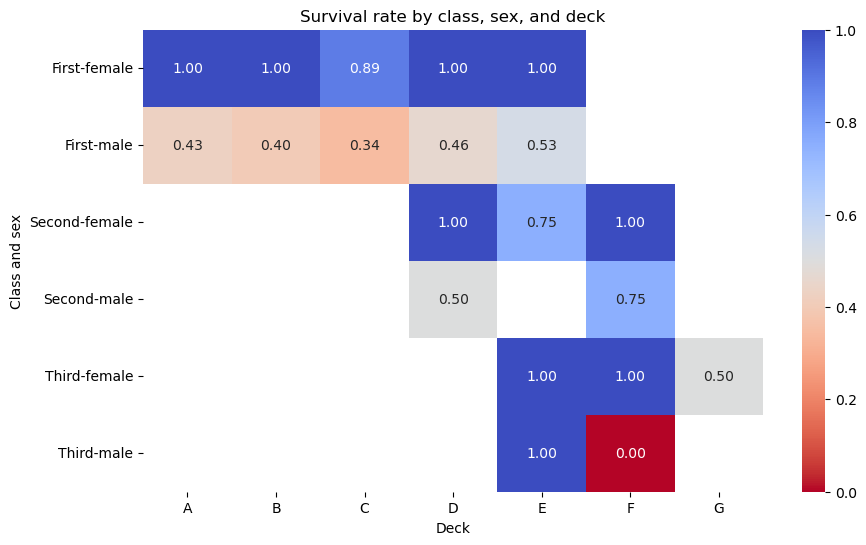

<Figure size 640x480 with 0 Axes>

In [3]:
# Step 9: Further subquerying by deck
# This is then plotted as a heatmap

query = """
SELECT
    pc.class_name,
    p.sex,
    c.deck,
    AVG(p.survived) AS survival_rate,
    COUNT(*) AS passengers_count
FROM passengers p
LEFT JOIN passenger_classes pc ON p.pclass_id = pc.pclass_id
LEFT JOIN cabins c ON p.cabin_id = c.cabin_id
GROUP BY pc.class_name, p.sex, c.deck
ORDER BY survival_rate DESC;
"""

df_query = pd.read_sql_query(query, conn)
df_pivot = df_query.pivot_table(
    index=['class_name', 'sex'],
    columns='deck',
    values='survival_rate'
)

plt.figure(figsize=(10,6))
sns.heatmap(df_pivot, annot=True, fmt='0.2f', cmap='coolwarm_r')
plt.title('Survival rate by class, sex, and deck')
plt.xlabel('Deck')
plt.ylabel('Class and sex')
plt.show()
plt.savefig('plots/heatmap.png', dpi=300, bbox_inches='tight')

In [4]:
# Step 10a: Jumping the shark (iceberg) - survival advantage within each class and sex
# For each passenger, I aim to compute their relative survival likelihood
# This is calculated from their sex and class average survival rate (after trial, age was also added as a differentiator,
# but had to be bucketed as there were not enough instances of each age to be meaningful)
# Passengers are then ranked by this score and the top 10 passengers are outputted

query = """
WITH base AS (
    SELECT
        p.passenger_id,
        pc.class_name,
        p.sex,
        p.age,
        p.survived,

        CASE 
            WHEN age IS NULL THEN 'unknown'
            WHEN age < 12 THEN 'child'
            WHEN age < 30 THEN 'young'
            WHEN age < 55 THEN 'adult'
            ELSE 'senior'
        END AS age_group,
        
        AVG(p.survived) OVER (PARTITION BY pc.class_name) AS class_survival_rate,
        AVG(p.survived) OVER (PARTITION BY p.sex) AS sex_survival_rate,
        AVG(p.survived) OVER (
            PARTITION BY CASE 
                WHEN age IS NULL THEN 'unknown'
                WHEN age < 12 THEN 'child'
                WHEN age < 30 THEN 'young'
                WHEN age < 55 THEN 'adult'
                ELSE 'senior'
            END
        ) AS age_survival_rate,

        AVG(p.survived) OVER () AS overall_survival_rate
    FROM passengers p
    JOIN passenger_classes pc
        ON p.pclass_id = pc.pclass_id
    WHERE p.age IS NOT NULL
),

scores AS (
    SELECT
        passenger_id,
        class_name,
        sex,
        age,
        age_group,
        survived,
        class_survival_rate,
        sex_survival_rate,
        age_survival_rate,
        overall_survival_rate,

        (survived - class_survival_rate) + (survived - sex_survival_rate) + (survived - age_survival_rate) AS survival_advantage,

        RANK() OVER (ORDER BY 
                    (survived - class_survival_rate)
                    + (survived - sex_survival_rate)
                    + (survived - age_survival_rate) DESC
                    ) AS advantage_rank
    FROM base
)

SELECT *
FROM scores
WHERE advantage_rank <= 10
ORDER BY advantage_rank;
"""

df_query = pd.read_sql_query(query, conn)
df_query
md_table = df_query.to_markdown(index=False)
print(md_table)

|   passenger_id | class_name   | sex   |   age | age_group   |   survived |   class_survival_rate |   sex_survival_rate |   age_survival_rate |   overall_survival_rate |   survival_advantage |   advantage_rank |
|---------------:|:-------------|:------|------:|:------------|-----------:|----------------------:|--------------------:|--------------------:|------------------------:|---------------------:|-----------------:|
|             82 | Third        | male  |    29 | young       |          1 |              0.239437 |            0.205298 |            0.370253 |                0.406162 |              2.18501 |                1 |
|            126 | Third        | male  |    12 | young       |          1 |              0.239437 |            0.205298 |            0.370253 |                0.406162 |              2.18501 |                1 |
|            128 | Third        | male  |    24 | young       |          1 |              0.239437 |            0.205298 |            0.370253 |    

In [6]:
# Step 10b: Diagnostic on another class
# We can see that Third Class young men occupy the positions of 'least likely' survivors.
# We might expect that an old man in Third Class would be top as older passengers were generally less likely to survive.
# Let's check if there are any in the dataset.

query_seniors = """
WITH base AS (
    SELECT
        p.passenger_id,
        pc.class_name,
        p.sex,
        p.age,
        p.survived,

        CASE 
            WHEN age < 12 THEN 'child'
            WHEN age < 30 THEN 'young'
            WHEN age < 55 THEN 'adult'
            ELSE 'senior'
        END AS age_group,
        
        AVG(p.survived) OVER (PARTITION BY pc.class_name) AS class_survival_rate,
        AVG(p.survived) OVER (PARTITION BY p.sex) AS sex_survival_rate,
        AVG(p.survived) OVER (
            PARTITION BY 
                CASE 
                    WHEN age < 12 THEN 'child'
                    WHEN age < 30 THEN 'young'
                    WHEN age < 55 THEN 'adult'
                    ELSE 'senior'
                END
        ) AS age_survival_rate,

        AVG(p.survived) OVER () AS overall_survival_rate
    FROM passengers p
    JOIN passenger_classes pc
        ON p.pclass_id = pc.pclass_id
    WHERE p.age IS NOT NULL
),

scores AS (
    SELECT
        passenger_id,
        class_name,
        sex,
        age,
        age_group,
        survived,
        class_survival_rate,
        sex_survival_rate,
        age_survival_rate,
        overall_survival_rate,

        (survived - class_survival_rate) + (survived - sex_survival_rate) + (survived - age_survival_rate) AS survival_advantage
    FROM base
)

SELECT *
FROM scores
WHERE class_name = 'Third'
  AND sex = 'male'
  AND age_group = 'senior'
ORDER BY survival_advantage DESC;
"""

df_seniors = pd.read_sql_query(query_seniors, conn)
df_seniors
md_table = df_seniors.to_markdown(index=False)
print(md_table)
# In this partial dataset, no Third Class males aged 55+ survived, of the 5 definitively categorised
# (excluding passengers for which age was not recorded).

|   passenger_id | class_name   | sex   |   age | age_group   |   survived |   class_survival_rate |   sex_survival_rate |   age_survival_rate |   overall_survival_rate |   survival_advantage |
|---------------:|:-------------|:------|------:|:------------|-----------:|----------------------:|--------------------:|--------------------:|------------------------:|---------------------:|
|             95 | Third        | male  |  59   | senior      |          0 |              0.239437 |            0.205298 |            0.309524 |                0.406162 |            -0.754258 |
|            117 | Third        | male  |  70.5 | senior      |          0 |              0.239437 |            0.205298 |            0.309524 |                0.406162 |            -0.754258 |
|            153 | Third        | male  |  55.5 | senior      |          0 |              0.239437 |            0.205298 |            0.309524 |                0.406162 |            -0.754258 |
|            281 | Third      